# Method 3 - Best Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

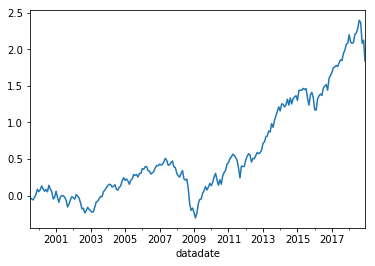

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.087859
2000-12-31   -0.101375
2001-12-31    0.009970
2002-12-31   -0.176608
2003-12-31    0.362425
2004-12-31    0.125305
2005-12-31    0.047301
2006-12-31    0.079841
2007-12-31   -0.017442
2008-12-31   -0.399675
2009-12-31    0.405450
2010-12-31    0.227793
2011-12-31   -0.023499
2012-12-31    0.157391
2013-12-31    0.364615
2014-12-31    0.068560
2015-12-31   -0.010877
2016-12-31    0.130666
2017-12-31    0.165116
2018-12-31   -0.079866
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1396.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.70e-159
Time:                        13:00:56   Log-Likelihood:                 770.13
No. Observations:                 234   AIC:                            -1530.
Df Residuals:                     229   BIC:                            -1513.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.522      0.129      -0.000       0.002
mktrf          0.9556      0.017     56.296      0.000       0.922       0.989
me             0.1955      0.020      9.902      0.000       0.157       0.234
ia             0.0716      0.030      2.387      0.018       0.013       0.131
roe           -0.0461      0.026     -1.794      0.074      -0.097       0.005
==============================================================================
Omnibus:                       66.694   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              851.014
Skew:                           0.672   Prob(JB):                    1.60e-185
Kurtosis:                      12.245   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1233.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-153
Time:                        13:00:56   Log-Likelihood:                 770.13
No. Observations:                 234   AIC:                            -1530.
Df Residuals:                     229   BIC:                            -1513.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.344      0.179      -0.000       0.002
mktrf          0.9556      0.027     35.676      0.000       0.903       1.008
me             0.1955      0.080      2.452      0.014       0.039       0.352
ia             0.0716      0.067      1.066      0.286      -0.060       0.203
roe           -0.0461      0.052     -0.884      0.377      -0.148       0.056
==============================================================================
Omnibus:                       66.694   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              851.014
Skew:                           0.672   Prob(JB):                    1.60e-185
Kurtosis:                      12.245   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1507.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.74e-163
Time:                        13:00:56   Log-Likelihood:                 770.13
No. Observations:                 234   AIC:                            -1530.
Df Residuals:                     229   BIC:                            -1513.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.302      0.193      -0.000       0.002
mktrf          0.9556      0.022     42.737      0.000       0.912       0.999
me             0.1955      0.085      2.292      0.022       0.028       0.363
ia             0.0716      0.059      1.224      0.221      -0.043       0.186
roe           -0.0461      0.048     -0.953      0.341      -0.141       0.049
==============================================================================
Omnibus:                       66.694   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              851.014
Skew:                           0.672   Prob(JB):                    1.60e-185
Kurtosis:                      12.245   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1198.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.94e-161
Time:                        13:00:56   Log-Likelihood:                 778.51
No. Observations:                 234   AIC:                            -1545.
Df Residuals:                     228   BIC:                            -1524.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.671      0.503      -0.001       0.002
mktrf          0.9712      0.016     59.054      0.000       0.939       1.004
smb            0.2745      0.022     12.647      0.000       0.232       0.317
hml            0.1183      0.026      4.624      0.000       0.068       0.169
rmw            0.0627      0.029      2.167      0.031       0.006       0.120
cma           -0.1137      0.037     -3.091      0.002      -0.186      -0.041
==============================================================================
Omnibus:                       69.165   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              574.360
Skew:                           0.879   Prob(JB):                    1.90e-125
Kurtosis:                      10.471   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     902.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.93e-148
Time:                        13:00:56   Log-Likelihood:                 778.51
No. Observations:                 234   AIC:                            -1545.
Df Residuals:                     228   BIC:                            -1524.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.621      0.534      -0.001       0.002
mktrf          0.9712      0.024     41.034      0.000       0.925       1.018
smb            0.2745      0.056      4.859      0.000       0.164       0.385
hml            0.1183      0.046      2.593      0.010       0.029       0.208
rmw            0.0627      0.035      1.799      0.072      -0.006       0.131
cma           -0.1137      0.051     -2.247      0.025      -0.213      -0.015
==============================================================================
Omnibus:                       69.165   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              574.360
Skew:                           0.879   Prob(JB):                    1.90e-125
Kurtosis:                      10.471   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1325.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.97e-166
Time:                        13:00:56   Log-Likelihood:                 778.51
No. Observations:                 234   AIC:                            -1545.
Df Residuals:                     228   BIC:                            -1524.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.614      0.539      -0.001       0.002
mktrf          0.9712      0.024     40.294      0.000       0.924       1.018
smb            0.2745      0.058      4.728      0.000       0.161       0.388
hml            0.1183      0.044      2.710      0.007       0.033       0.204
rmw            0.0627      0.031      1.993      0.046       0.001       0.124
cma           -0.1137      0.044     -2.578      0.010      -0.200      -0.027
==============================================================================
Omnibus:                       69.165   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              574.360
Skew:                           0.879   Prob(JB):                    1.90e-125
Kurtosis:                      10.471   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1565.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.88e-165
Time:                        13:00:56   Log-Likelihood:                 782.99
No. Observations:                 234   AIC:                            -1556.
Df Residuals:                     229   BIC:                            -1539.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.865      0.063   -6.06e-05       0.002
mktrf          0.9302      0.015     62.879      0.000       0.901       0.959
smb            0.2492      0.018     13.495      0.000       0.213       0.286
hml            0.1186      0.018      6.463      0.000       0.082       0.155
umd           -0.0798      0.012     -6.633      0.000      -0.104      -0.056
==============================================================================
Omnibus:                       23.233   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.997
Skew:                           0.112   Prob(JB):                     5.25e-22
Kurtosis:                       6.162   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1479.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.90e-162
Time:                        13:00:56   Log-Likelihood:                 782.99
No. Observations:                 234   AIC:                            -1556.
Df Residuals:                     229   BIC:                            -1539.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.614      0.106      -0.000       0.002
mktrf          0.9302      0.020     46.394      0.000       0.891       0.970
smb            0.2492      0.057      4.371      0.000       0.137       0.361
hml            0.1186      0.028      4.273      0.000       0.064       0.173
umd           -0.0798      0.028     -2.844      0.004      -0.135      -0.025
==============================================================================
Omnibus:                       23.233   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.997
Skew:                           0.112   Prob(JB):                     5.25e-22
Kurtosis:                       6.162   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     2047.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.49e-178
Time:                        13:00:56   Log-Likelihood:                 782.99
No. Observations:                 234   AIC:                            -1556.
Df Residuals:                     229   BIC:                            -1539.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.535      0.125      -0.000       0.002
mktrf          0.9302      0.020     46.949      0.000       0.891       0.969
smb            0.2492      0.056      4.415      0.000       0.139       0.360
hml            0.1186      0.030      3.980      0.000       0.060       0.177
umd           -0.0798      0.028     -2.886      0.004      -0.134      -0.026
==============================================================================
Omnibus:                       23.233   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.997
Skew:                           0.112   Prob(JB):                     5.25e-22
Kurtosis:                       6.162   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     532.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.53e-73
Time:                        13:00:56   Log-Likelihood:                 366.81
No. Observations:                 120   AIC:                            -723.6
Df Residuals:                     115   BIC:                            -709.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.478      0.142      -0.001       0.004
mktrf          0.9595      0.030     32.016      0.000       0.900       1.019
me             0.1416      0.030      4.783      0.000       0.083       0.200
ia             0.0923      0.046      1.991      0.049       0.000       0.184
roe           -0.0555      0.041     -1.352      0.179      -0.137       0.026
==============================================================================
Omnibus:                       33.650   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.558
Skew:                           0.897   Prob(JB):                     1.48e-27
Kurtosis:                       7.636   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     537.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-73
Time:                        13:00:56   Log-Likelihood:                 366.81
No. Observations:                 120   AIC:                            -723.6
Df Residuals:                     115   BIC:                            -709.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.199      0.230      -0.001       0.004
mktrf          0.9595      0.036     26.708      0.000       0.889       1.030
me             0.1416      0.086      1.638      0.101      -0.028       0.311
ia             0.0923      0.085      1.083      0.279      -0.075       0.259
roe           -0.0555      0.069     -0.800      0.423      -0.191       0.080
==============================================================================
Omnibus:                       33.650   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.558
Skew:                           0.897   Prob(JB):                     1.48e-27
Kurtosis:                       7.636   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     815.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.30e-83
Time:                        13:00:56   Log-Likelihood:                 366.81
No. Observations:                 120   AIC:                            -723.6
Df Residuals:                     115   BIC:                            -709.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      1.084      0.279      -0.001       0.005
mktrf          0.9595      0.029     32.750      0.000       0.902       1.017
me             0.1416      0.094      1.501      0.133      -0.043       0.327
ia             0.0923      0.076      1.218      0.223      -0.056       0.241
roe           -0.0555      0.063     -0.874      0.382      -0.180       0.069
==============================================================================
Omnibus:                       33.650   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.558
Skew:                           0.897   Prob(JB):                     1.48e-27
Kurtosis:                       7.636   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     445.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.92e-73
Time:                        13:00:56   Log-Likelihood:                 369.84
No. Observations:                 120   AIC:                            -727.7
Df Residuals:                     114   BIC:                            -711.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.016      0.312      -0.001       0.003
mktrf          1.0139      0.031     32.761      0.000       0.953       1.075
smb            0.2546      0.035      7.264      0.000       0.185       0.324
hml            0.0967      0.043      2.252      0.026       0.012       0.182
rmw            0.1060      0.051      2.093      0.039       0.006       0.206
cma           -0.0895      0.055     -1.613      0.109      -0.199       0.020
==============================================================================
Omnibus:                       27.267   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.320
Skew:                           0.779   Prob(JB):                     5.97e-18
Kurtosis:                       6.665   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     469.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.80e-74
Time:                        13:00:56   Log-Likelihood:                 369.84
No. Observations:                 120   AIC:                            -727.7
Df Residuals:                     114   BIC:                            -711.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.950      0.342      -0.001       0.003
mktrf          1.0139      0.041     24.568      0.000       0.933       1.095
smb            0.2546      0.075      3.394      0.001       0.108       0.402
hml            0.0967      0.069      1.397      0.162      -0.039       0.232
rmw            0.1060      0.063      1.677      0.093      -0.018       0.230
cma           -0.0895      0.076     -1.184      0.236      -0.238       0.059
==============================================================================
Omnibus:                       27.267   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.320
Skew:                           0.779   Prob(JB):                     5.97e-18
Kurtosis:                       6.665   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     719.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.98e-84
Time:                        13:00:57   Log-Likelihood:                 369.84
No. Observations:                 120   AIC:                            -727.7
Df Residuals:                     114   BIC:                            -711.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.903      0.367      -0.001       0.004
mktrf          1.0139      0.044     22.786      0.000       0.927       1.101
smb            0.2546      0.077      3.304      0.001       0.104       0.406
hml            0.0967      0.068      1.432      0.152      -0.036       0.229
rmw            0.1060      0.066      1.613      0.107      -0.023       0.235
cma           -0.0895      0.066     -1.358      0.174      -0.219       0.040
==============================================================================
Omnibus:                       27.267   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.320
Skew:                           0.779   Prob(JB):                     5.97e-18
Kurtosis:                       6.665   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     615.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.29e-76
Time:                        13:00:57   Log-Likelihood:                 375.08
No. Observations:                 120   AIC:                            -740.2
Df Residuals:                     115   BIC:                            -726.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.983      0.050    2.64e-06       0.004
mktrf          0.9329      0.025     37.853      0.000       0.884       0.982
smb            0.2250      0.028      8.019      0.000       0.169       0.281
hml            0.1338      0.028      4.762      0.000       0.078       0.189
umd           -0.0901      0.017     -5.201      0.000      -0.124      -0.056
==============================================================================
Omnibus:                        3.893   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.582
Skew:                          -0.082   Prob(JB):                        0.101
Kurtosis:                       3.943   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     724.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.58e-80
Time:                        13:00:57   Log-Likelihood:                 375.08
No. Observations:                 120   AIC:                            -740.2
Df Residuals:                     115   BIC:                            -726.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.852      0.064      -0.000       0.004
mktrf          0.9329      0.031     30.482      0.000       0.873       0.993
smb            0.2250      0.061      3.708      0.000       0.106       0.344
hml            0.1338      0.034      3.951      0.000       0.067       0.200
umd           -0.0901      0.031     -2.890      0.004      -0.151      -0.029
==============================================================================
Omnibus:                        3.893   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.582
Skew:                          -0.082   Prob(JB):                        0.101
Kurtosis:                       3.943   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     952.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.07e-87
Time:                        13:00:57   Log-Likelihood:                 375.08
No. Observations:                 120   AIC:                            -740.2
Df Residuals:                     115   BIC:                            -726.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.768      0.077      -0.000       0.004
mktrf          0.9329      0.031     29.958      0.000       0.872       0.994
smb            0.2250      0.059      3.788      0.000       0.109       0.341
hml            0.1338      0.035      3.807      0.000       0.065       0.203
umd           -0.0901      0.029     -3.056      0.002      -0.148      -0.032
==============================================================================
Omnibus:                        3.893   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.582
Skew:                          -0.082   Prob(JB):                        0.101
Kurtosis:                       3.943   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3503.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.10e-114
Time:                        13:00:57   Log-Likelihood:                 485.50
No. Observations:                 114   AIC:                            -961.0
Df Residuals:                     109   BIC:                            -947.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.664      0.009       0.000       0.002
mktrf          0.9176      0.010     89.196      0.000       0.897       0.938
me             0.3577      0.016     22.522      0.000       0.326       0.389
ia            -0.0145      0.022     -0.660      0.511      -0.058       0.029
roe           -0.0593      0.019     -3.065      0.003      -0.098      -0.021
==============================================================================
Omnibus:                        2.104   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.575
Skew:                          -0.183   Prob(JB):                        0.455
Kurtosis:                       3.444   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2208.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.66e-103
Time:                        13:00:57   Log-Likelihood:                 485.50
No. Observations:                 114   AIC:                            -961.0
Df Residuals:                     109   BIC:                            -947.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.749      0.006       0.000       0.002
mktrf          0.9176      0.015     62.269      0.000       0.889       0.946
me             0.3577      0.022     15.909      0.000       0.314       0.402
ia            -0.0145      0.024     -0.616      0.538      -0.061       0.032
roe           -0.0593      0.016     -3.786      0.000      -0.090      -0.029
==============================================================================
Omnibus:                        2.104   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.575
Skew:                          -0.183   Prob(JB):                        0.455
Kurtosis:                       3.444   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2802.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.07e-109
Time:                        13:00:57   Log-Likelihood:                 485.50
No. Observations:                 114   AIC:                            -961.0
Df Residuals:                     109   BIC:                            -947.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.945      0.003       0.000       0.002
mktrf          0.9176      0.015     60.738      0.000       0.888       0.947
me             0.3577      0.024     14.864      0.000       0.311       0.405
ia            -0.0145      0.021     -0.690      0.490      -0.056       0.027
roe           -0.0593      0.015     -3.960      0.000      -0.089      -0.030
==============================================================================
Omnibus:                        2.104   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.575
Skew:                          -0.183   Prob(JB):                        0.455
Kurtosis:                       3.444   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2786.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.17e-112
Time:                        13:00:57   Log-Likelihood:                 485.69
No. Observations:                 114   AIC:                            -959.4
Df Residuals:                     108   BIC:                            -943.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.537      0.593      -0.001       0.001
mktrf          0.9219      0.010     93.692      0.000       0.902       0.941
smb            0.3381      0.016     21.163      0.000       0.306       0.370
hml            0.0453      0.020      2.224      0.028       0.005       0.086
rmw           -0.0838      0.025     -3.359      0.001      -0.133      -0.034
cma           -0.0683      0.032     -2.157      0.033      -0.131      -0.006
==============================================================================
Omnibus:                        6.058   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                9.839
Skew:                          -0.028   Prob(JB):                      0.00730
Kurtosis:                       4.438   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1492.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.72e-98
Time:                        13:00:57   Log-Likelihood:                 485.69
No. Observations:                 114   AIC:                            -959.4
Df Residuals:                     108   BIC:                            -943.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.463      0.643      -0.001       0.001
mktrf          0.9219      0.017     55.643      0.000       0.889       0.954
smb            0.3381      0.020     17.073      0.000       0.299       0.377
hml            0.0453      0.012      3.748      0.000       0.022       0.069
rmw           -0.0838      0.020     -4.275      0.000      -0.122      -0.045
cma           -0.0683      0.024     -2.843      0.004      -0.115      -0.021
==============================================================================
Omnibus:                        6.058   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                9.839
Skew:                          -0.028   Prob(JB):                      0.00730
Kurtosis:                       4.438   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2867.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.66e-113
Time:                        13:00:57   Log-Likelihood:                 485.69
No. Observations:                 114   AIC:                            -959.4
Df Residuals:                     108   BIC:                            -943.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.446      0.656      -0.001       0.001
mktrf          0.9219      0.016     58.579      0.000       0.891       0.953
smb            0.3381      0.023     14.729      0.000       0.293       0.383
hml            0.0453      0.011      4.147      0.000       0.024       0.067
rmw           -0.0838      0.017     -4.855      0.000      -0.118      -0.050
cma           -0.0683      0.021     -3.187      0.001      -0.110      -0.026
==============================================================================
Omnibus:                        6.058   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                9.839
Skew:                          -0.028   Prob(JB):                      0.00730
Kurtosis:                       4.438   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3050.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.26e-111
Time:                        13:00:57   Log-Likelihood:                 477.67
No. Observations:                 114   AIC:                            -945.3
Df Residuals:                     109   BIC:                            -931.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.879e-06      0.000      0.021      0.983      -0.001       0.001
mktrf          0.9278      0.010     88.862      0.000       0.907       0.949
smb            0.3597      0.016     22.094      0.000       0.327       0.392
hml            0.0468      0.017      2.793      0.006       0.014       0.080
umd           -0.0282      0.013     -2.226      0.028      -0.053      -0.003
==============================================================================
Omnibus:                        5.686   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                8.490
Skew:                           0.099   Prob(JB):                       0.0143
Kurtosis:                       4.322   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1277.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-90
Time:                        13:00:57   Log-Likelihood:                 477.67
No. Observations:                 114   AIC:                            -945.3
Df Residuals:                     109   BIC:                            -931.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.879e-06      0.000      0.019      0.985      -0.001       0.001
mktrf          0.9278      0.017     53.056      0.000       0.894       0.962
smb            0.3597      0.020     18.283      0.000       0.321       0.398
hml            0.0468      0.017      2.776      0.005       0.014       0.080
umd           -0.0282      0.016     -1.721      0.085      -0.060       0.004
==============================================================================
Omnibus:                        5.686   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                8.490
Skew:                           0.099   Prob(JB):                       0.0143
Kurtosis:                       4.322   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2080.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.74e-102
Time:                        13:00:57   Log-Likelihood:                 477.67
No. Observations:                 114   AIC:                            -945.3
Df Residuals:                     109   BIC:                            -931.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.879e-06      0.000      0.019      0.985      -0.001       0.001
mktrf          0.9278      0.017     56.108      0.000       0.895       0.960
smb            0.3597      0.022     16.602      0.000       0.317       0.402
hml            0.0468      0.015      3.091      0.002       0.017       0.077
umd           -0.0282      0.016     -1.769      0.077      -0.059       0.003
==============================================================================
Omnibus:                        5.686   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                8.490
Skew:                           0.099   Prob(JB):                       0.0143
Kurtosis:                       4.322   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""